#Задание 4 - Перенос обучения (transfer learning) и тонкая настройка (fine-tuning)

In [0]:
import json
import os
import csv
import urllib
from io import BytesIO
from PIL import Image

from socket import timeout

from google.colab import files

In [0]:
!uptime

 19:10:51 up 7 min,  0 users,  load average: 0.07, 0.14, 0.09


In [0]:
!hostname

5b91336a8856


In [0]:
!nvidia-smi

Fri Jan 17 19:10:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip3 install -q torch
!pip3 install -q torchvision
!pip3 install -q Pillow

In [0]:
# Download train data
!wget "https://storage.googleapis.com/dlcourse_ai/train.zip"
!unzip -q "train.zip"

train_folder = "train_kaggle/"
# Count number of files in the train folder, should be 4603
print('Number of files in the train folder', len(os.listdir(train_folder)))

# Download test data
!wget "https://storage.googleapis.com/dlcourse_ai/test.zip"
!unzip -q "test.zip"

test_folder = "test_kaggle/"
# Count number of files in the test folder, should be 1150
print('Number of files in the test folder', len(os.listdir(test_folder)))

--2020-01-17 19:11:15--  https://storage.googleapis.com/dlcourse_ai/train.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 2607:f8b0:4001:c12::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 562348083 (536M) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>] 536.30M  96.7MB/s    in 5.6s    

2020-01-17 19:11:21 (95.6 MB/s) - ‘train.zip’ saved [562348083/562348083]

Number of files in the train folder 4603
--2020-01-17 19:11:28--  https://storage.googleapis.com/dlcourse_ai/test.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 2607:f8b0:4001:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 140788786 (134M) [application/zip]
Saving to: ‘test.zip’

test.zip            100%[

In [0]:
import torch
from torchvision import models
from torch.utils.data import Dataset, SubsetRandomSampler
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0") # Let's make sure GPU is available!

#Имплементируем свой Dataset для загрузки данных

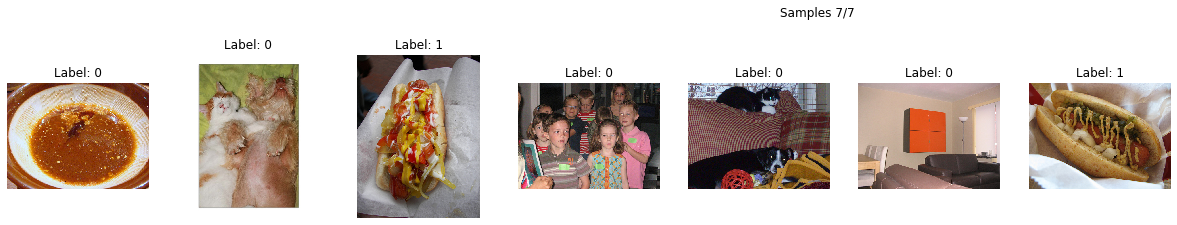

In [0]:
class HotdogOrNotDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.transform = transform
        self.folder = folder
        self.file_names = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

    def __len__(self):
        return len(self.file_names)
    
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()

        img_id = self.file_names[index]
        img_id = os.path.join(self.folder, img_id)
        # with open(img_id, 'rb') as f:
        #     img = Image.open(io.BytesIO(f.read()))
        img = Image.open(img_id)

        y = 0
        check_list = ['frankfurter', 'chili-dog', 'hotdog']
        if any(x in img_id for x in check_list):
            y = 1

        if self.transform:
            img = self.transform(img)

        return img, y, img_id

def visualize_samples(dataset, indices, title=None, count=10):
    # visualize random 10 samples
    plt.figure(figsize=(count*3,3))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)), y=1.1)        
    for i, index in enumerate(display_indices):    
        x, y, _ = dataset[index]
        plt.subplot(1,count,i+1)
        plt.title("Label: %s" % y)
        plt.imshow(x)
        plt.grid(False)
        plt.axis('off')   
    
orig_dataset = HotdogOrNotDataset(train_folder)
indices = np.random.choice(np.arange(len(orig_dataset)), 7, replace=False)

visualize_samples(orig_dataset, indices, "Samples")

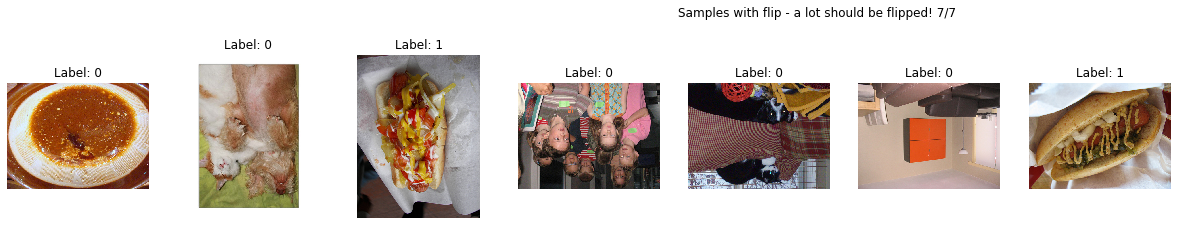

In [0]:
# Let's make sure transforms work!
dataset = HotdogOrNotDataset(train_folder, transform=transforms.RandomVerticalFlip(0.9))

visualize_samples(dataset, indices, "Samples with flip - a lot should be flipped!")

#Создаем Dataset для тренировки

In [0]:
# First, lets load the dataset
train_dataset = HotdogOrNotDataset(train_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )
test_dataset = HotdogOrNotDataset(test_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )

In [0]:
batch_size = 64

data_size = len(dataset)
validation_fraction = .2


val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         sampler=val_sampler)
# Notice that we create test data loader in a different way. We don't have the labels.
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [0]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y, _) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value


        if scheduler:
            scheduler.step()

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Epoch: %i, Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (epoch+1, ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Copy implementation from previous assignment
    # Don't forget to move the data to device before running it through the model!
    
    correct_samples = 0
    total_samples = 0
    for i_step, (x, y, _) in enumerate(loader):
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        prediction = model(x_gpu)
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y_gpu)
        total_samples += y_gpu.shape[0]
    return float(correct_samples) / total_samples

#Использование заранее натренированной сети (pretrained network)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 144MB/s] 


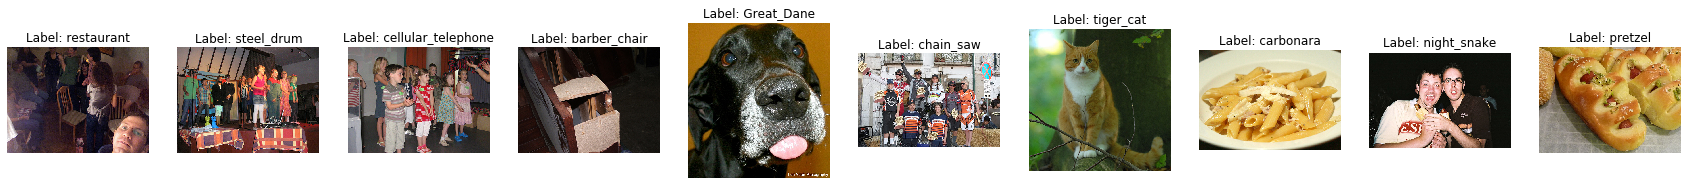

In [0]:
# Thanks to https://discuss.pytorch.org/t/imagenet-classes/4923/2
def load_imagenet_classes():
    classes_json = urllib.request.urlopen('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json').read()
    classes = json.loads(classes_json)
    
    # TODO: Process it to return dict of class index to name
    return { int(k): v[-1] for k, v in classes.items()}

# TODO: Run this model on 10 random images of your dataset and visualize what it predicts
def test_model_pred(model, classes, dataset, count=10):
    show_indices = np.random.choice(np.arange(len(dataset)), count, replace=False)
    show_sampler = SubsetRandomSampler(show_indices)
    show_loader = torch.utils.data.DataLoader(dataset, sampler=show_sampler)

    model.eval()
    model.cuda()

    plt.figure(figsize=(count*3,3))
    for i_step, (x, _, path) in enumerate(show_loader):
        x_gpu = x.to(device)
        pred = model(x_gpu)
        pred = int(torch.argmax(pred))
        pred_class = imagenet_classes[pred]

        plt.subplot(1,count,i_step+1)
        plt.title("Label: %s" % pred_class)
        x_show = plt.imread(path[0])
        plt.imshow(x_show)
        plt.grid(False)
        plt.axis('off')


model = models.resnet18(pretrained=True)
imagenet_classes = load_imagenet_classes()
test_model_pred(model, imagenet_classes, train_dataset, 10)

#resnet18

In [0]:
print(models.resnet18())

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#Перенос обучения (transfer learning) - тренировать только последний слой
заменить последний слой на новый и тренировать только его, заморозив остальные

In [0]:
import torch.nn as nn
import torch.optim as optim

model = models.resnet18(pretrained=True)
# TODO: Freeze all the layers of this model and add a new output layer
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 2)
model.type(torch.cuda.FloatTensor)
model = model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 2)

test_accuracy = compute_accuracy(model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Epoch: 1, Average loss: 0.343464, Train accuracy: 0.843334, Val accuracy: 0.905435
Epoch: 2, Average loss: 0.212790, Train accuracy: 0.919088, Val accuracy: 0.920652
Test accuracy: 0.7122


#Перенос обучения (transfer learning) - тренировать всю модель
заменить последний слой на новый и обучать всю модель целиком

In [0]:
import torch.nn as nn
import torch.optim as optim

model = models.resnet18(pretrained=True)
# TODO: Add a new output layer and train the whole model
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

model.fc = nn.Linear(model.fc.in_features, 2)
model.type(torch.cuda.FloatTensor)
model = model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 5)

test_accuracy = compute_accuracy(model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Epoch: 1, Average loss: 0.307165, Train accuracy: 0.863970, Val accuracy: 0.935870
Epoch: 2, Average loss: 0.137077, Train accuracy: 0.953027, Val accuracy: 0.940217
Epoch: 3, Average loss: 0.099089, Train accuracy: 0.964160, Val accuracy: 0.947826
Epoch: 4, Average loss: 0.069920, Train accuracy: 0.978550, Val accuracy: 0.946739
Epoch: 5, Average loss: 0.054679, Train accuracy: 0.984795, Val accuracy: 0.946739
Test accuracy: 0.6957


#Перенос обучения (transfer learning) - разные скорости обучения для разных слоев
использовать разные скорости обучения для новых (здесь только последний fc) и старых слоев

In [0]:
import torch.nn as nn
import torch.optim as optim

model = models.resnet18(pretrained=True)
# TODO: Add a new output layer
# Train new layer with learning speed 0.001 and old layers with 0.0001
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

model.fc = nn.Linear(model.fc.in_features, 2)
model.type(torch.cuda.FloatTensor)
model = model.to(device)
#print(model)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
params = [
              {'params': model.conv1.parameters()},
              {'params': model.layer1.parameters()},
              {'params': model.layer2.parameters()},
              {'params': model.layer3.parameters()},
              {'params': model.layer4.parameters()},
              {'params': model.fc.parameters(), 'lr': 1e-2},
         ]
optimizer = optim.SGD(params, lr=0.001, momentum=0.9)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 5)

test_accuracy = compute_accuracy(model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Epoch: 1, Average loss: 0.263122, Train accuracy: 0.894651, Val accuracy: 0.944565
Epoch: 2, Average loss: 0.108759, Train accuracy: 0.961988, Val accuracy: 0.940217
Epoch: 3, Average loss: 0.078725, Train accuracy: 0.973120, Val accuracy: 0.951087
Epoch: 4, Average loss: 0.024866, Train accuracy: 0.990497, Val accuracy: 0.952174
Epoch: 5, Average loss: 0.012784, Train accuracy: 0.997556, Val accuracy: 0.951087
Test accuracy: 0.6687


#Визуализируем метрики и ошибки модели

In [0]:
from torch.utils.data.sampler import Sampler

class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        data_source (Dataset): dataset to sample from
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of booleans of model predictions
    grount_truth: np array of boolean of actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    
    sampler = SubsetSampler(indices)
    loader = torch.utils.data.DataLoader(dataset, sampler=sampler)
    
    predictions = []
    ground_truth = []
    for i, (x, y, _) in enumerate(loader):
        x_gpu = x.to(device)
        y_pred = model(x_gpu)
        y_pred = int(torch.argmax(y_pred))

        ground_truth.append(int(y))
        predictions.append(y_pred)

    return predictions, ground_truth

In [0]:
predictions, gt = evaluate_model(model, train_dataset, val_indices)

In [0]:
false_positive_indices = []
false_negatives_indices = []
for i in range(len(predictions)):
    if predictions[i] and not gt[i]:
        false_positive_indices.append(val_indices[i])
    if not predictions[i] and gt[i]:
        false_negatives_indices.append(val_indices[i])

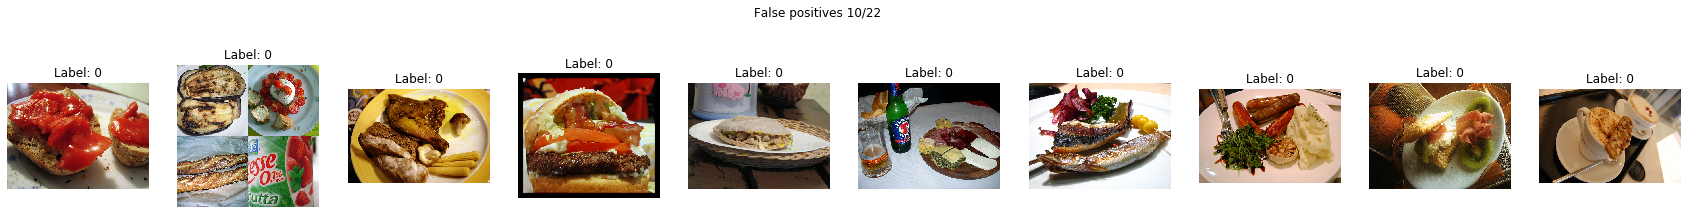

In [0]:
visualize_samples(orig_dataset, false_positive_indices, "False positives")

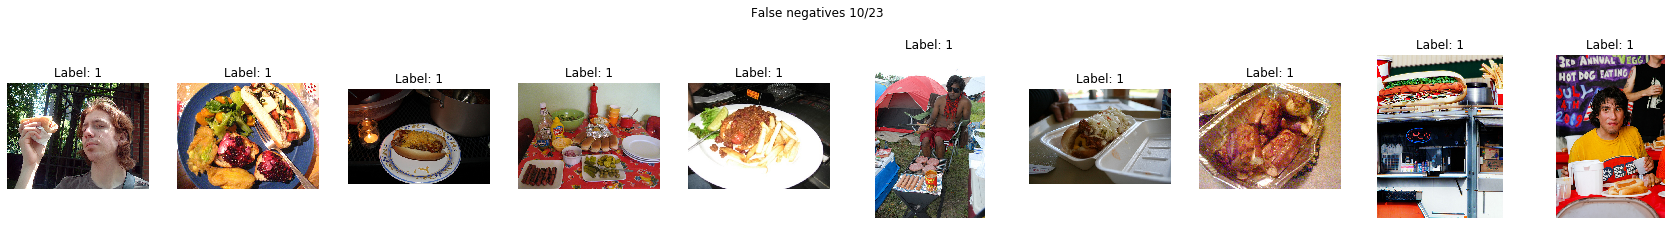

In [0]:
visualize_samples(orig_dataset, false_negatives_indices, "False negatives")

In [0]:
import sklearn.metrics as metrics
def binary_classification_metrics(prediction, ground_truth):
    precision = 0
    recall = 0
    accuracy = 0
    f1 = 0

    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for i in range(len(prediction)):
        if prediction[i] == ground_truth[i] == True:
            tp += 1
        elif prediction[i] == ground_truth[i] == False:
            tn += 1
        elif prediction[i] == True and ground_truth[i] == False:
            fp += 1
        elif prediction[i] == False and ground_truth[i] == True:
            fn +=1

    accuracy = (tp + tn) / len(prediction)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = (2 * precision * recall) / (precision + recall)
    
    return precision, recall, f1, accuracy

In [0]:
precision, recall, f1, accuracy = binary_classification_metrics(predictions, gt)
print("F1: %4.3f, P: %4.3f, R: %4.3f, A: %4.3f" % (f1, precision, recall, accuracy))

F1: 0.925, P: 0.927, R: 0.924, A: 0.951


#test #0
data valid: 920  
data train: 3683 + 1473 (augment)

optimizer: SGD  
scheduler: StepLR

In [0]:
validation_fraction = .2
augment_fraction = .4
lr = 1e-2
l2 = 1e-2
momentum = 0.9
epoch_num = 4
batch_size = 64
anneal_coeff = 0.3
anneal_epochs = 3


tfs = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

tfs_augment = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(hue=.10, saturation=.5),
    transforms.RandomRotation(10, resample=Image.BILINEAR),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = HotdogOrNotDataset(train_folder, transform=tfs)
augment_dataset = HotdogOrNotDataset(train_folder, transform=tfs_augment)
test_dataset = HotdogOrNotDataset(test_folder, transform=tfs)

data_size = len(train_dataset)
valid_size = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
#np.random.seed(42)
np.random.shuffle(indices)
val_indices, train_indices = indices[:valid_size], indices[valid_size:]

train_size = len(train_indices)
augment_size = int(np.floor((augment_fraction) * train_size))
augment_indices = train_indices.copy()
np.random.shuffle(augment_indices)
augment_indices = augment_indices[:augment_size]
augment_indices = [i+train_size for i in augment_indices]
train_indices = np.append(train_indices, augment_indices)
train_dataset = torch.utils.data.ConcatDataset([train_dataset, augment_dataset])
train_sampler = SubsetRandomSampler(train_indices)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)

val_sampler = SubsetRandomSampler(val_indices)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
print(data_size, valid_size, train_size, len(train_indices)) ######


nn_model = models.resnet18(pretrained=True)

# Freeze all the layers
for param in nn_model.parameters():
    param.requires_grad = False

nn_model.fc = nn.Linear(nn_model.fc.in_features, 2)
nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
#params = [
#              {'params': nn_model.conv1.parameters()},
#              {'params': nn_model.layer1.parameters()},
#              {'params': nn_model.layer2.parameters()},
#              {'params': nn_model.layer3.parameters()},
#              {'params': nn_model.layer4.parameters()},
#              {'params': nn_model.fc.parameters(), 'lr': 1e-2},
#         ]
params = nn_model.fc.parameters()
optimizer = optim.SGD(params, lr=lr, weight_decay=l2, momentum=momentum)
scheduler = optim.lr_scheduler.StepLR(optimizer, anneal_epochs, anneal_coeff)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, epoch_num, scheduler)

4603 920 3683 5156
Epoch: 1, Average loss: 0.251431, Train accuracy: 0.901668, Val accuracy: 0.959783
Epoch: 2, Average loss: 0.157676, Train accuracy: 0.941040, Val accuracy: 0.966304
Epoch: 3, Average loss: 0.204384, Train accuracy: 0.923196, Val accuracy: 0.963043
Epoch: 4, Average loss: 0.136693, Train accuracy: 0.949379, Val accuracy: 0.961957


F1: 0.94058, P: 0.94218, R: 0.93898, A: 0.96196


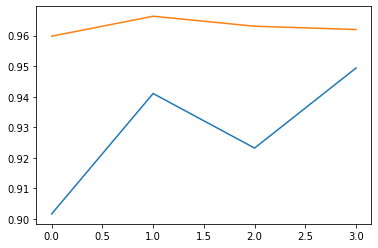

In [0]:
predictions, ground_truth = evaluate_model(nn_model, train_dataset, val_indices)
precision, recall, f1, accuracy = binary_classification_metrics(predictions, ground_truth)
print("F1: %4.5f, P: %4.5f, R: %4.5f, A: %4.5f" % (f1, precision, recall, accuracy))
plt.plot(train_history)
plt.plot(val_history);

#test #1
data valid: 920  
data train: 3683 + 1473 (augment)  
 
optimizer: Adam  
scheduler: CosineAnnealingLR

In [0]:
validation_fraction = .2
augment_fraction = .4
lr = 1e-2
l2 = 1e-4
momentum = 0.9
epoch_num = 5
batch_size = 64
# anneal_coeff = 0.8
# anneal_epochs = 2


tfs = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

tfs_augment = transforms.Compose([
    transforms.Resize((224, 224)),
#    transforms.ColorJitter(hue=.10, saturation=.5),
#    transforms.RandomRotation(10, resample=Image.BILINEAR),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = HotdogOrNotDataset(train_folder, transform=tfs)
augment_dataset = HotdogOrNotDataset(train_folder, transform=tfs_augment)
test_dataset = HotdogOrNotDataset(test_folder, transform=tfs)

data_size = len(train_dataset)
valid_size = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
#np.random.seed(42)
np.random.shuffle(indices)
val_indices, train_indices = indices[:valid_size], indices[valid_size:]

train_size = len(train_indices)
augment_size = int(np.floor((augment_fraction) * train_size))
augment_indices = train_indices.copy()
np.random.shuffle(augment_indices)
augment_indices = augment_indices[:augment_size]
augment_indices = [i+train_size for i in augment_indices]
train_indices = np.append(train_indices, augment_indices)
train_dataset = torch.utils.data.ConcatDataset([train_dataset, augment_dataset])
train_sampler = SubsetRandomSampler(train_indices)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)

val_sampler = SubsetRandomSampler(val_indices)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
print(data_size, valid_size, train_size, len(train_indices)) ######


nn_model = models.resnet18(pretrained=True)

# Freeze all the layers
# for param in nn_model.parameters():
#     param.requires_grad = False

# for name, child in nn_model.named_children():
#     if name == 'layer4':
#         break;
#     for param in child.parameters():
#         param.requires_grad = False

nn_model.fc = nn.Linear(nn_model.fc.in_features, 2)
# def init_normal(m):
#     if type(m) == nn.Linear:
#         nn.init.xavier_normal_(m.weight)
# nn_model.apply(init_normal)

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
params = [
             {'params': nn_model.conv1.parameters(), 'lr': 1e-7},
             {'params': nn_model.layer1.parameters(), 'lr': 1e-6},
             {'params': nn_model.layer2.parameters(), 'lr': 1e-6},
             {'params': nn_model.layer3.parameters(), 'lr': 1e-5},
             {'params': nn_model.layer4.parameters(), 'lr': 1e-5},
             {'params': nn_model.fc.parameters(), 'lr': lr},
        ]
optimizer = optim.Adam(params, lr=lr, weight_decay=l2)
#optimizer = optim.SGD(params, lr=lr, weight_decay=l2, momentum=momentum)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epoch_num, eta_min=0)
#scheduler = optim.lr_scheduler.StepLR(optimizer, anneal_epochs, anneal_coeff)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, epoch_num, scheduler)

4603 920 3683 5156
Epoch: 1, Average loss: 0.348970, Train accuracy: 0.884213, Val accuracy: 0.933696
Epoch: 2, Average loss: 0.106870, Train accuracy: 0.958883, Val accuracy: 0.966304
Epoch: 3, Average loss: 0.052400, Train accuracy: 0.981963, Val accuracy: 0.963043
Epoch: 4, Average loss: 0.041045, Train accuracy: 0.987199, Val accuracy: 0.960870
Epoch: 5, Average loss: 0.030591, Train accuracy: 0.991854, Val accuracy: 0.965217


F1: 0.94326, P: 0.94662, R: 0.93993, A: 0.96522


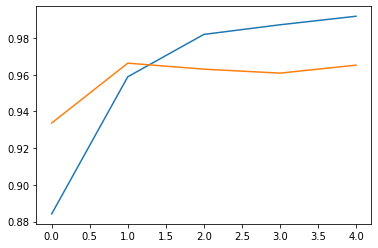

In [0]:
predictions, ground_truth = evaluate_model(nn_model, train_dataset, val_indices)
precision, recall, f1, accuracy = binary_classification_metrics(predictions, ground_truth)
print("F1: %4.5f, P: %4.5f, R: %4.5f, A: %4.5f" % (f1, precision, recall, accuracy))
plt.plot(train_history)
plt.plot(val_history);

#test #2
data valid: 920  
data train: 3683 + 1473 (augment)  
 
optimizer: Adam  
scheduler: CosineAnnealingLR  
  
xavier_normal_ for fc

In [0]:
validation_fraction = .2
augment_fraction = .4
lr = 1e-3 #fc
l2 = 1e-2 #fc
# momentum = 0.9
epoch_num = 5
batch_size = 64
# anneal_coeff = 0.4
# anneal_epochs = 2

lr_1 = 1e-4 #layer4
l2_1 = 1e-2 #layer4

lr_2 = 1e-6 #layer3
l2_2 = 3e-1 #layer3


tfs = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

tfs_augment = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.ColorJitter(hue=.10, saturation=.15),
    transforms.RandomRotation(15, resample=Image.BILINEAR),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = HotdogOrNotDataset(train_folder, transform=tfs)
augment_dataset = HotdogOrNotDataset(train_folder, transform=tfs_augment)
test_dataset = HotdogOrNotDataset(test_folder, transform=tfs)

data_size = len(train_dataset)
valid_size = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
#np.random.seed(42)
np.random.shuffle(indices)
val_indices, train_indices = indices[:valid_size], indices[valid_size:]

train_size = len(train_indices)
augment_size = int(np.floor((augment_fraction) * train_size))
augment_indices = train_indices.copy()
np.random.shuffle(augment_indices)
augment_indices = augment_indices[:augment_size]
augment_indices = [i+train_size for i in augment_indices]
train_indices = np.append(train_indices, augment_indices)
train_dataset = torch.utils.data.ConcatDataset([train_dataset, augment_dataset])
train_sampler = SubsetRandomSampler(train_indices)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)

val_sampler = SubsetRandomSampler(val_indices)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
print(data_size, valid_size, train_size, len(train_indices)) ######


nn_model = models.resnet18(pretrained=True)

# Freeze all the layers
# for param in nn_model.parameters():
#     param.requires_grad = False

for name, child in nn_model.named_children():
    if name == 'layer3':
        break;
    for param in child.parameters():
        param.requires_grad = False

nn_model.fc = nn.Linear(nn_model.fc.in_features, 2)
def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight)
nn_model.apply(init_normal)

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
params = [
             {'params': nn_model.layer3.parameters(), 'lr': lr_2, 'weight_decay': l2_2},
             {'params': nn_model.layer4.parameters(), 'lr': lr_1, 'weight_decay': l2_1},
             {'params': nn_model.fc.parameters(), 'lr': lr, 'weight_decay': l2},
        ]
#optimizer = optim.SGD(params, lr=lr, weight_decay=l2, momentum=momentum, nesterov=True)
optimizer = optim.Adam(params)
#scheduler = optim.lr_scheduler.StepLR(optimizer, anneal_epochs, anneal_coeff)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epoch_num, eta_min=0)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, epoch_num, scheduler)

4603 920 3683 5156
Epoch: 1, Average loss: 0.190163, Train accuracy: 0.931148, Val accuracy: 0.958696
Epoch: 2, Average loss: 0.038283, Train accuracy: 0.987005, Val accuracy: 0.968478
Epoch: 3, Average loss: 0.014237, Train accuracy: 0.996897, Val accuracy: 0.971739
Epoch: 4, Average loss: 0.006711, Train accuracy: 0.998448, Val accuracy: 0.975000
Epoch: 5, Average loss: 0.005074, Train accuracy: 0.999418, Val accuracy: 0.978261


F1: 0.96337, P: 0.97048, R: 0.95636, A: 0.97826


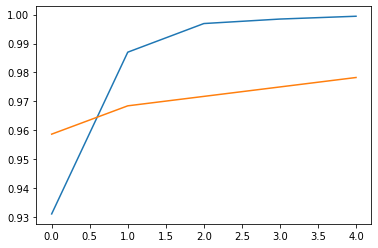

In [0]:
predictions, ground_truth = evaluate_model(nn_model, train_dataset, val_indices)
precision, recall, f1, accuracy = binary_classification_metrics(predictions, ground_truth)
print("F1: %4.5f, P: %4.5f, R: %4.5f, A: %4.5f" % (f1, precision, recall, accuracy))
plt.plot(train_history)
plt.plot(val_history);

#test #3
data valid: 920  
data train: 3683 + 2946 (augment)  
 
optimizer: Adam  
scheduler: CosineAnnealingLR  
  
xavier_normal_ for fc

In [0]:
validation_fraction = .2
augment_fraction = .8
lr = 1e-3 #fc
l2 = 1e-2 #fc
# momentum = 0.9
epoch_num = 5
batch_size = 64
# anneal_coeff = 0.4
# anneal_epochs = 2

lr_1 = 1e-4 #layer4
l2_1 = 3e-1 #layer4

lr_2 = 1e-6  #layer3
l2_2 = 4e-1  #layer3


tfs = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

tfs_augment = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(hue=.10, saturation=.15),
    transforms.RandomRotation(15, resample=Image.BILINEAR),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = HotdogOrNotDataset(train_folder, transform=tfs)
augment_dataset = HotdogOrNotDataset(train_folder, transform=tfs_augment)
test_dataset = HotdogOrNotDataset(test_folder, transform=tfs)

data_size = len(train_dataset)
valid_size = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
#np.random.seed(42)
np.random.shuffle(indices)
val_indices, train_indices = indices[:valid_size], indices[valid_size:]

train_size = len(train_indices)
augment_size = int(np.floor((augment_fraction) * train_size))
augment_indices = train_indices.copy()
np.random.shuffle(augment_indices)
augment_indices = augment_indices[:augment_size]
augment_indices = [i+train_size for i in augment_indices]
train_indices = np.append(train_indices, augment_indices)
train_dataset = torch.utils.data.ConcatDataset([train_dataset, augment_dataset])
train_sampler = SubsetRandomSampler(train_indices)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)

val_sampler = SubsetRandomSampler(val_indices)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
print(data_size, valid_size, train_size, len(train_indices)) ######


nn_model_1 = models.resnet18(pretrained=True)

# Freeze all the layers
# for param in nn_model_1.parameters():
#     param.requires_grad = False

for name, child in nn_model_1.named_children():
    if name == 'layer3':
        break;
    for param in child.parameters():
        param.requires_grad = False

nn_model_1.fc = nn.Linear(nn_model_1.fc.in_features, 2)
def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight)
nn_model_1.apply(init_normal)

nn_model_1.type(torch.cuda.FloatTensor)
nn_model_1.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
params = [
             {'params': nn_model_1.layer3.parameters(), 'lr': lr_2, 'weight_decay': l2_2},
             {'params': nn_model_1.layer4.parameters(), 'lr': lr_1, 'weight_decay': l2_1},
             {'params': nn_model_1.fc.parameters(), 'lr': lr, 'weight_decay': l2},
        ]
#optimizer = optim.SGD(params, lr=lr, weight_decay=l2, momentum=momentum, nesterov=True)
optimizer = optim.Adam(params)
#scheduler = optim.lr_scheduler.StepLR(optimizer, anneal_epochs, anneal_coeff)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epoch_num, eta_min=0)
loss_history, train_history, val_history = train_model(nn_model_1, train_loader, val_loader, loss, optimizer, epoch_num, scheduler)

4603 920 3683 6629
Epoch: 1, Average loss: 0.218727, Train accuracy: 0.907226, Val accuracy: 0.963043
Epoch: 2, Average loss: 0.139524, Train accuracy: 0.949163, Val accuracy: 0.947826
Epoch: 3, Average loss: 0.090940, Train accuracy: 0.966209, Val accuracy: 0.958696
Epoch: 4, Average loss: 0.059219, Train accuracy: 0.977976, Val accuracy: 0.960870
Epoch: 5, Average loss: 0.033666, Train accuracy: 0.988083, Val accuracy: 0.978261


F1: 0.96564, P: 0.96897, R: 0.96233, A: 0.97826


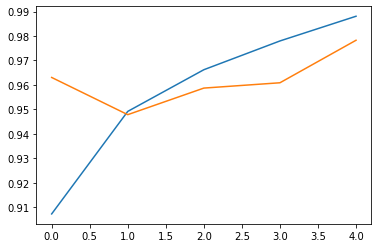

In [0]:
predictions, ground_truth = evaluate_model(nn_model_1, train_dataset, val_indices)
precision, recall, f1, accuracy = binary_classification_metrics(predictions, ground_truth)
print("F1: %4.5f, P: %4.5f, R: %4.5f, A: %4.5f" % (f1, precision, recall, accuracy))
plt.plot(train_history)
plt.plot(val_history);

#Визуализируйте ошибки лучшей модели

In [0]:
false_positive_indices = []
false_negatives_indices = []
for i in range(len(predictions)):
    if predictions[i] and not ground_truth[i]:
        false_positive_indices.append(val_indices[i])
    if not predictions[i] and ground_truth[i]:
        false_negatives_indices.append(val_indices[i])

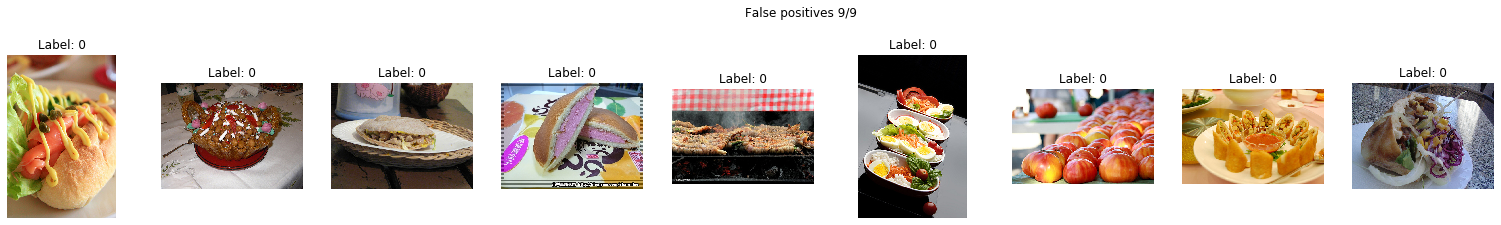

In [0]:
visualize_samples(orig_dataset, false_positive_indices, "False positives")

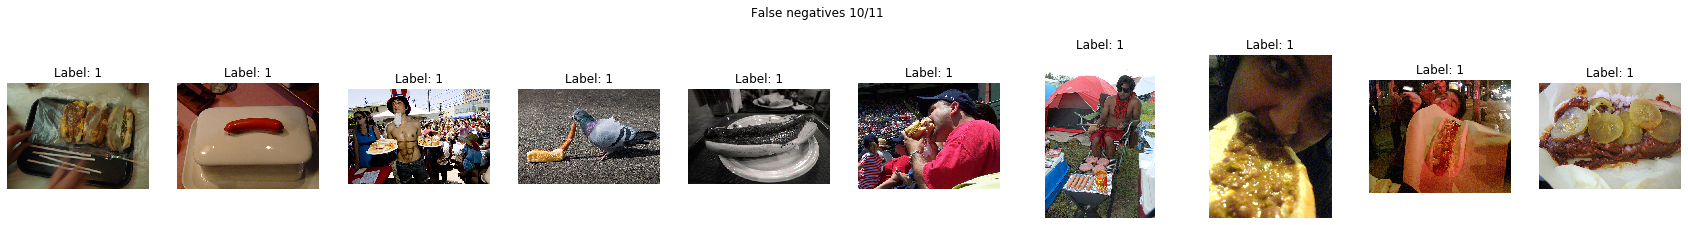

In [0]:
visualize_samples(orig_dataset, false_negatives_indices, "False negatives")

#kaggle
https://www.kaggle.com/c/hotdogornot

In [0]:
import os

predictions, _ = evaluate_model(nn_model_1, test_dataset, range(len(test_dataset)))
image_id = [os.path.basename(d[2]) for d in test_dataset]

In [0]:
# Так можно создать csv файл, чтобы затем загрузить его на kaggle
# Ожидаемый формат csv-файла:
# image_id,label
# 10000.jpg,1
# 10001.jpg,1
# 10002.jpg,0
# 10003.jpg,1
# 10004.jpg,0

with open('subm.csv', 'w') as submissionFile:
    writer = csv.writer(submissionFile)
    writer.writerow(['image_id', 'label'])
    writer.writerows(zip(image_id,predictions))

In [0]:
# А так можно скачать файл с Google Colab
files.download('subm.csv')

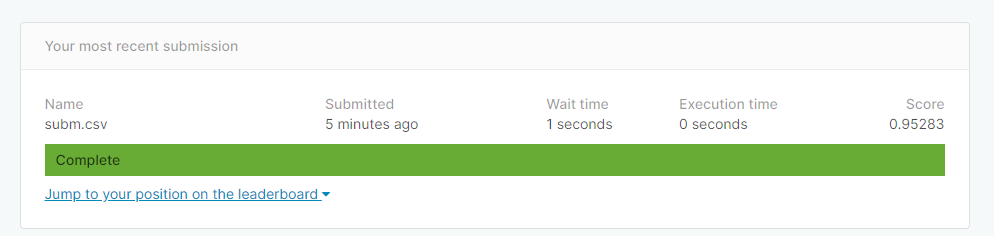